In [54]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid") # better looking plots
import deepxde as dde

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [60]:
Lmax = 100
p_stress = 0.1

C11 = np.exp(1.55)
C33 = np.exp(0.316)

lmbd = torch.tensor(C11 - 2*C33).to(device)
mu = torch.tensor(C33).to(device) 

phy_params = {'lmbd': lmbd, 'mu': mu}

In [135]:
def E_nn(X,U):
    #calculate the strain given the displacement
    Exx = dde.grad.jacobian(U, X, i=0, j=0)
    Eyy = dde.grad.jacobian(U, X, i=1, j=1)
    Exy = 0.5 * (dde.grad.jacobian(U, X, i=1, j=0) +dde.grad.jacobian(U, X, i=0, j=1))
    return Exx, Eyy, Exy

def S_nn(E,params):
    lmbd = params["lmbd"].cpu().detach()
    mu = params["mu"].cpu().detach()
    #calculate the stress given the strain
    Sxx = (2 * mu + lmbd) * E[0] + lmbd * E[1]
    Syy = (2 * mu + lmbd) * E[1] + lmbd * E[0] 
    Sxy = 2 * mu * E[2]
    return Sxx, Syy, Sxy

def PDE(X,S,params):
    """
    the PDE of the problem (momentum balance)
    X is the spatial coordinate of shape (N,2) (x,y) 
    S is the stress tensor of shape (N,3) (Sxx, Syy, Sxy)
    """

    Sxx, Syy, Sxy = S
    S = torch.stack((Sxx.reshape(-1,1), Syy.reshape(-1,1), Sxy.reshape(-1,1)), axis=1)
        
    dSxx_x = dde.grad.jacobian(S, X, i=0, j=0)
    dSyy_y = dde.grad.jacobian(S, X, i=1, j=1)
    dSxy_x = dde.grad.jacobian(S, X, i=2, j=0)
    dSxy_y = dde.grad.jacobian(S, X, i=2, j=1)

    momentum_x = dSxx_x + dSxy_y 
    momentum_y = dSyy_y + dSxy_x 
    
    return [momentum_x, momentum_y]

def PDE_Unet(x,net_output):
    """"
    x: input tensor of shape (N,2), the spatial coordinates x and y
    u: output tensor of shape (N,2), the displacement u_x and u_y
    return: the PDE loss
    """
    E = E_nn(x,net_output)
    S = S_nn(E,phy_params)
    pde = PDE(x,S,phy_params)
    return pde

def Epot_Unet(x,net_output):
    """"
    x: input tensor of shape (N,2), the spatial coordinates x and y
    u: output tensor of shape (N,2), the displacement u_x and u_y
    return: the potential energy
    """
    E = E_nn(x,net_output)
    S = S_nn(E,phy_params)
    E_pot = E_potential(x,net_output,S,phy_params)
    return [E_pot]


# boundary condition
def boundary_Sxx(x,_):
    return np.isclose(x[0], Lmax)

def boundary_Syy(x,_):
    return np.isclose(x[1], Lmax)

def BCvalue_Sxx(x):
    return p_stress*torch.ones_like(x[:,0])

def BCvalue_Syy(x):
    return torch.zeros_like(x[:,0])

def Sxx_Unet(inputs, outputs, X):
    E_pred = E_nn(inputs,outputs)
    S_pred = S_nn(E_pred,phy_params)
    Sxx_pred = S_pred[0]
    return torch.square(Sxx_pred- BCvalue_Sxx(inputs))

def Syy_Unet(inputs, outputs, X):
    E_pred = E_nn(inputs,outputs)
    S_pred = S_nn(E_pred,phy_params)
    Syy_pred = S_pred[1].squeeze()
    return torch.square(Syy_pred- BCvalue_Syy(inputs))

def HardBC_Unet(x,net_output):  
    Ux = net_output[:,0]*x[:,1]
    Uy = net_output[:,1]*x[:,0]*x[:,1]
    return torch.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1))) 

def Unet_exact(x,lib="np"):
    if lib == 'torch':
        hstack = torch.hstack
    elif lib == 'np':
        hstack = np.hstack
    # ground truth displacement
    Ux = 0.025712*x[:,0]
    Uy = -0.010741*x[:,1]
    return hstack((Ux.reshape(-1,1),Uy.reshape(-1,1))) 

In [134]:
BCvalue_Syy([torch.tensor([0.0,0.0])])

0

In [138]:
# Physics Informed Neural Networks

# choosing a configuration
#net parameters
net_type= 'USnet'
n_layers = 3
size_layers = 4
size_output = 2
activation = "tanh"


#loss parameters
loss_type= ['pde','energy'][0]#the energy loss appears to crash LBFGS and provide less accurate results with Adam. PDE loss is therefore used in the following
num_samples= 100
num_domain= num_samples**2
num_boundary= num_samples
train_distribution= 'Hammersley'

#boundary conditions
bc_type= 'hard'

#optimizer
optimizers= ["adam","L-BFGS"]
learning_rates= [1e-3,None]
iterations= [10,None]


config = {'net_type':net_type,'n_layers':n_layers,'size_layers':size_layers,'activation':activation,
        'loss_type':loss_type,'num_samples':num_samples,'train_distribution':train_distribution,
        'bc_type':bc_type,
        'optimizers':optimizers,'learning_rates':learning_rates,'iterations':iterations}


geom = dde.geometry.Rectangle([0, 0], [Lmax, Lmax])
net = dde.nn.FNN([2] + [size_layers]*n_layers + [size_output], activation, 'Glorot uniform')
net_exact = Unet_exact

bc_Sxx = dde.icbc.OperatorBC(geom, Sxx_Unet, boundary_Sxx)
bc_Syy = dde.icbc.OperatorBC(geom, Syy_Unet, boundary_Syy)

bc = []
bc = [bc_Sxx,bc_Syy] #Soft BCs for stress
net.apply_output_transform(HardBC_Unet)

pde_net = PDE_Unet
energy_net = Epot_Unet
total_loss = pde_net

data = dde.data.PDE(
    geom,
    total_loss,
    bc,
    num_domain=num_domain,
    num_boundary=num_boundary,
    num_test= num_domain,
    train_distribution = train_distribution,
    solution=net_exact,
)
model = dde.Model(data, net)


In [139]:


def train_model(model,config,callbacks = [],model_save_path = None):
    learning_rates = config['learning_rates']
    optimizers = config['optimizers']
    iterations = config['iterations']
    
    for i,optimizer in enumerate(optimizers) :    
        if optimizer == "adam":
            model.compile("adam", lr=learning_rates[i], metrics=["l2 relative error"])
            losshistory, train_state  = model.train(iterations=iterations[i],callbacks = callbacks,model_save_path=model_save_path)
        elif optimizer == "L-BFGS":
            model.compile("L-BFGS", metrics=["l2 relative error"])
            losshistory, train_state  = model.train(callbacks = callbacks,model_save_path=model_save_path)
    return losshistory, train_state

losshistory, train_state = train_model(model,config,callbacks = [],model_save_path = None)


Compiling model...
'compile' took 0.000570 s

Training model...

0         [1.04e+04, 9.27e+04, 4.52e+11, 5.33e+03]    [1.02e+04, 9.16e+04, 4.52e+11, 5.33e+03]    [5.63e+02]    
10        [8.91e+03, 8.04e+04, 2.53e+11, 3.86e+05]    [8.75e+03, 7.84e+04, 2.53e+11, 3.86e+05]    [5.64e+02]    

Best model at step 10:
  train loss: 2.53e+11
  test loss: 2.53e+11
  test metric: [5.64e+02]

'train' took 12.913809 s

Compiling model...
'compile' took 0.000363 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
10        [8.91e+03, 8.04e+04, 2.53e+11, 3.86e+05]    [8.75e+03, 7.84e+04, 2.53e+11, 3.86e+05]    [5.64e+02]    


In [123]:
# plotting utilities

def pcolor_plot(AX, X, Y, C, title,colormap="copper",**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

def plot_field(domain,model,output_func=None,V_exact=None,plot_diff=False,n_points=10000,fields_name=None):

    X = np.linspace(domain[0][0], domain[0][1], int(np.sqrt(n_points)))
    Y = np.linspace(domain[1][0], domain[1][1], int(np.sqrt(n_points)))
    Xgrid, Ygrid = np.meshgrid(X, Y)
    Xinput = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))

    plotify = lambda x: x.reshape(Xgrid.shape)

    if output_func is None:
        V_nn = model.predict(Xinput)
    else:
        V_nn = model.predict(Xinput, operator=output_func)

    V_nn = [plotify(V) for V in V_nn]

    n_fields = len(V_nn) if type(V_nn) is list else 1
    n_plot = 1

    if fields_name is None:
        fields_name = V_exact.__name__.replace('_exact','') if V_exact is not None else 'V'

    coord = ["_x","_y","_xy"] if n_fields > 1 else [""]
    fields_name = [fields_name + coord[i] for i in range(n_fields)]

    if V_exact is not None:
        V_exact = V_exact(Xinput)
        V_exact = [plotify(V) for V in V_exact]
        n_plot = 3 if plot_diff else 2
        
    fig, ax = plt.subplots(n_fields, n_plot, figsize=(4*n_plot, 3*n_fields), dpi=200)

    for i in range(n_fields):
        subax = ax if n_fields == 1 else ax[i] 

        if V_exact is not None:

            cmax = max(V_nn[i].max(), V_exact[i].max())
            cmin = min(V_nn[i].min(), V_exact[i].min())

            im1 = pcolor_plot(subax[0], Xgrid, Ygrid, V_exact[i], f"{fields_name[i]}*", cmin=cmin, cmax=cmax)
            im2 = pcolor_plot(subax[1], Xgrid, Ygrid, V_nn[i], f"{fields_name[i]}_nn", cmin=cmin, cmax=cmax)

            fig.colorbar(im1, ax=subax[1])
        else:
            im1 = pcolor_plot(subax, Xgrid, Ygrid, V_nn[i], f"{fields_name[i]}_nn")
            fig.colorbar(im1, ax=subax)

        if plot_diff:
            diff = V_nn[i] - V_exact[i]
            abs_diff = np.abs(diff)
            cmax = abs_diff.max() if diff.max() > 0 else 0
            cmin = -abs_diff.max() if diff.min() < 0 else 0
            im3 = pcolor_plot(subax[2], Xgrid, Ygrid,diff, f"{fields_name[i]}_nn - {fields_name[i]}*", cmin=cmin, cmax=cmax, colormap="coolwarm")
            fig.colorbar(im3, ax=subax[2])
            subax[2].text(1.025,0.5,f"mean($\mid${fields_name[i]}_nn - {fields_name[i]}*$\mid$): {np.mean(abs_diff):.2e}", fontsize=6,ha = "center",rotation = "vertical",rotation_mode = "anchor",transform= subax[2].transAxes)

    return fig

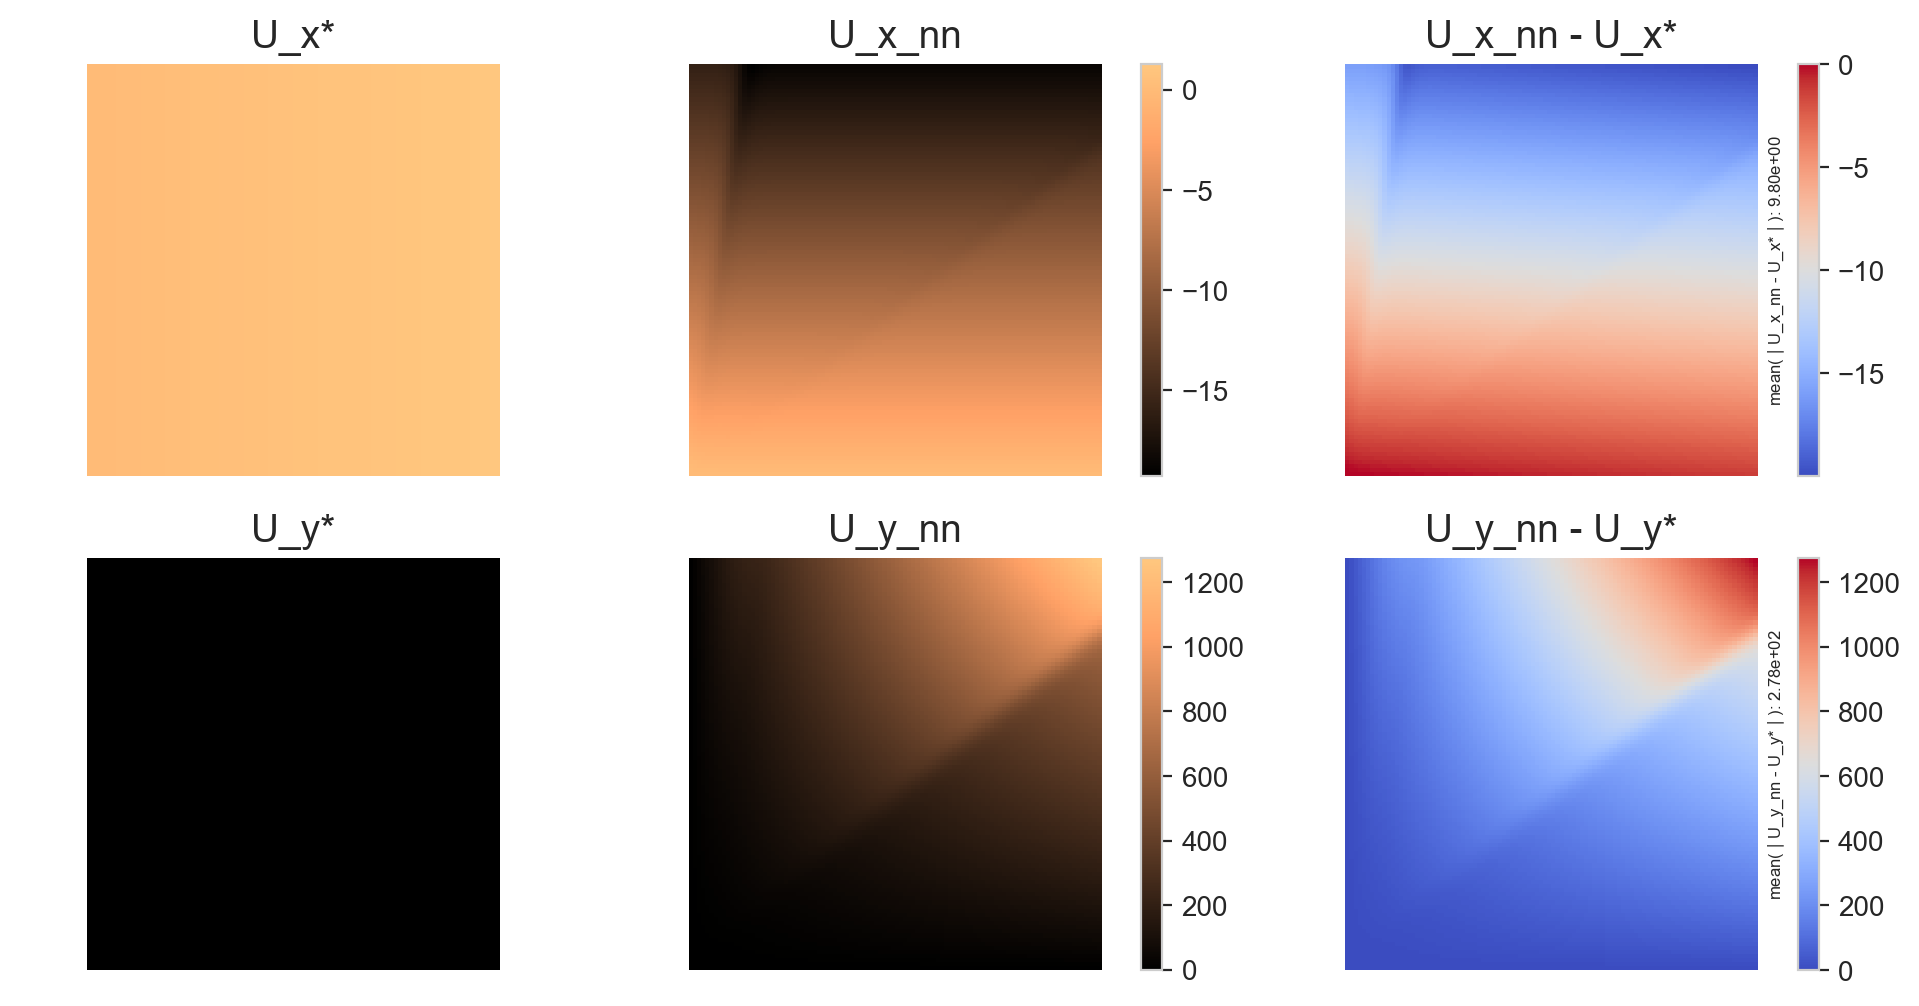

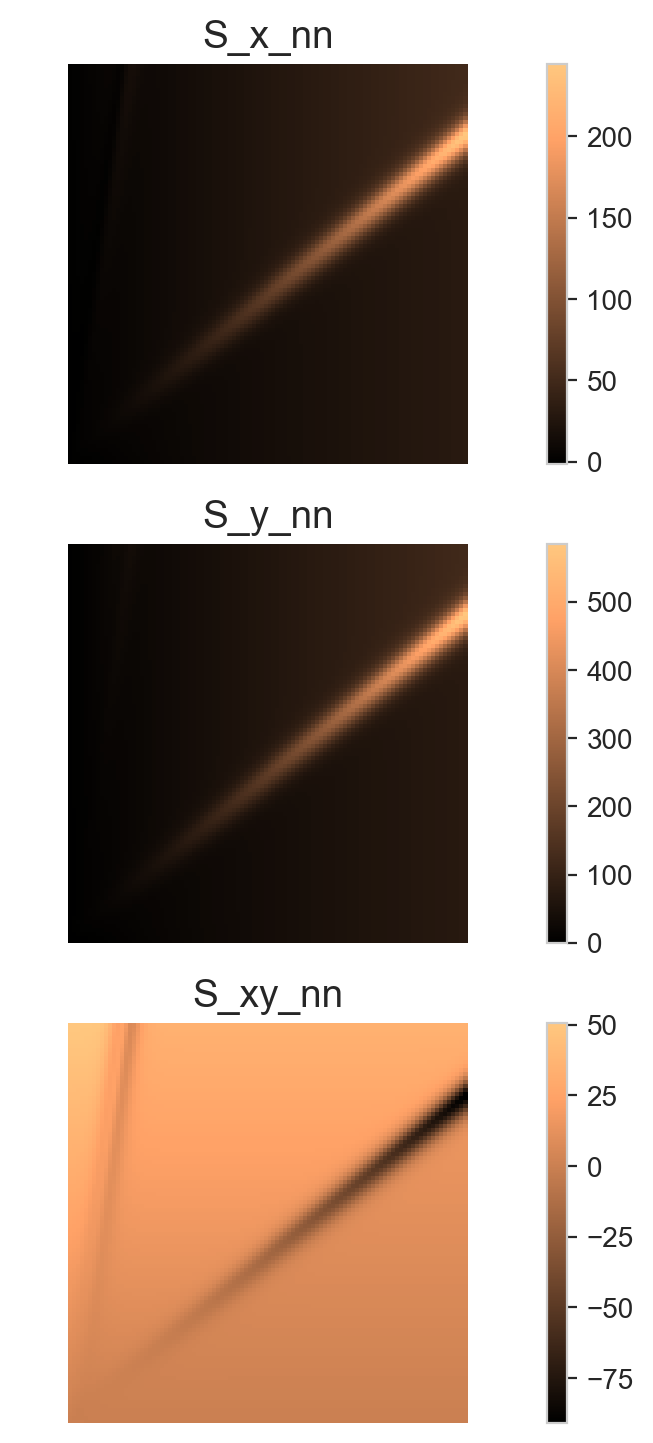

In [127]:
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white" # Set figure background to white for notebook with dark mode

domain = [[0, Lmax/2], [0, Lmax/2]]
n_points = 10000

U_output = lambda x, u: (u[:,0], u[:,1])
U_exact_plot = lambda x: [Unet_exact(x,lib="np")[:,0],Unet_exact(x,lib="np")[:,1]]
S_output = lambda x, u: S_nn(E_nn(x,u),phy_params)

fig = plot_field(domain, model, output_func=U_output, V_exact=U_exact_plot, plot_diff=True,fields_name="U")
fig = plot_field(domain, model, output_func=S_output, fields_name="S")